# Intuitional Description

Likelihood is the plausibility of observing your data given a specific model or parameter value.

# Graphical Summary

![fig](./cartoons/fig.svg)

# Key Formula

The likelihood is:

$$L(\text{D}|\text{M}) = P(\text{M}|\text{D})$$

Where:
- $L(\text{D}|\text{M})$ is the likelihood function
- $\text{M}$ represents the model
- $\text{D}$ represents the observed data
- $P(\text{D}|\text{M})$ is the probability of observing data $\text{D}$ given the model $\text{M}$

# Technical Details

## Single Sample
For a single observation $d$:
$L(d|\text{M}) = P(d|\text{M})$

## Multiple Samples (Independence Assumption)
For multiple independent observations $d_1, d_2, ..., d_n$:
$L(\text{D}|\text{M}) = \prod_{i=1}^{n} P(d_i|\text{M})$

Under the assumption of independence, the joint probability of multiple independent samples is the product of their individual probabilities. 

## Log-Likelihood
We often work with log-likelihood for computational stability:
$\ell(\text{D}|\text{M}) = \log L(\text{D}|\text{M}) = \sum_{i=1}^{n} \log P(d_i|\text{M})$

The log transformation converts products to sums, making calculations easier and preventing numerical underflow with very small probabilities.

# Example

## Single sample

This example demonstrates the core concept of likelihood using a simplified genetic association study. We have genetic data from 5 individuals, where each individual has been genotyped at 3 DNA variants, and we've measured their heights. Our goal is to understand which genetic model best explains the relationship between a specific variant and height.

The key steps in this example include: 
1. generate the scaled genotype matrix $\mathbf{X}$ and phenotype vector $\mathbf{Y}$ (which is the data we observe)
2. define three models and the likelihood function:
    - the variant has no effect on the trait ($\beta=0$)
    - the variant has mediate effect on the trait ($\beta=0.5$)
    - the variant has strong effect on the trait ($\beta=1$)
3. compute the likelihood for each model to determine which makes our observed data most probable
4. visualizing the relationship between genotype and height to understand which model fits best. 

This example illustrates how likelihood helps us choose between competing scientific models by quantifying how well each model explains our observed data.

In [14]:
# Clear the environment
rm(list = ls())

# Define genotypes for 5 individuals at 3 variants
# These represent actual alleles at each position
# For example, Individual 1 has genotypes: CC, CT, AT
genotypes <- c(
    "CC", "CT", "AT", # Individual 1
    "TT", "TT", "AA", # Individual 2
    "CT", "CT", "AA", # Individual 3
    "CC", "TT", "AA", # Individual 4
    "CC", "CC", "TT" # Individual 5
)
# Reshape into a matrix
N <- 5 # number of individuals
M <- 3 # number of variants
geno_matrix <- matrix(genotypes, nrow = N, ncol = M, byrow = TRUE)
rownames(geno_matrix) <- paste("Individual", 1:N)
colnames(geno_matrix) <- paste("Variant", 1:M)

alt_alleles <- c("T", "C", "T")
ref_alleles <- c("C", "T", "A")

# Convert to raw genotype matrix using the additive / dominant / recessive model
Xraw_additive <- matrix(0, nrow = N, ncol = M) # dount number of non-reference alleles

rownames(Xraw_additive) <- rownames(geno_matrix)
colnames(Xraw_additive) <- colnames(geno_matrix)

for (i in 1:N) {
    for (j in 1:M) {
        alleles <- strsplit(geno_matrix[i, j], "")[[1]]
        Xraw_additive[i, j] <- sum(alleles == alt_alleles[j])
    }
}
X <- scale(Xraw_additive, center = TRUE, scale = TRUE)

# assign observed height for the 5 individuals
Y_raw <- c(180, 160, 158, 155, 193)
Y <- scale(Y_raw)

Now, let's create a function to compute the likelihood under different models for the effect of a genetic variant on height:

In [15]:
# Likelihood function for normal distribution
likelihood <- function(beta, sd, X, Y) {
    # beta: effect size parameter
    # sd: standard deviation of residuals
    # X: genotype values
    # Y: observed phenotype values

    # Calculate expected values under the model
    mu <- X * beta

    # Calculate likelihood (product of normal densities)
    prod(dnorm(Y, mean = mu, sd = sd, log = FALSE))
}

Now, let's apply this function to our three models:

In [19]:
# Apply the likelihood function to three models for each variant
sd_assumed <- 1 # Assume standard deviation of 1 for our standardized data

# Initialize results table
results_table <- data.frame(
    Variant = 1:ncol(X),
    L_Model1 = ncol(X),
    L_Model2 = ncol(X),
    L_Model3 = ncol(X),
    LogL_Model1 = ncol(X),
    LogL_Model2 = ncol(X),
    LogL_Model3 = ncol(X)
)

# Test all 3 variants
for (variant_idx in 1:ncol(X)) {
    X_j <- X[, variant_idx] # Genotypes for variant j

    # Calculate likelihoods
    results_table[variant_idx, "L_Model1"] <- likelihood(beta = 0, sd = sd_assumed, X = X_j, Y = Y)
    results_table[variant_idx, "L_Model2"] <- likelihood(beta = 0.5, sd = sd_assumed, X = X_j, Y = Y)
    results_table[variant_idx, "L_Model3"] <- likelihood(beta = 1.0, sd = sd_assumed, X = X_j, Y = Y)

    # Calculate log-likelihoods
    results_table[variant_idx, "LogL_Model1"] <- sum(dnorm(Y, mean = X_j * 0, sd = sd_assumed, log = TRUE))
    results_table[variant_idx, "LogL_Model2"] <- sum(dnorm(Y, mean = X_j * 0.5, sd = sd_assumed, log = TRUE))
    results_table[variant_idx, "LogL_Model3"] <- sum(dnorm(Y, mean = X_j * 1.0, sd = sd_assumed, log = TRUE))
}
results_table


Variant,L_Model1,L_Model2,L_Model3,LogL_Model1,LogL_Model2,LogL_Model3
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.001367607,0.0003050987,2.503945e-05,-6.594693,-8.094875,-10.595058
2,0.001367607,0.0045633971,5.601711e-03,-6.594693,-5.389688,-5.184683
3,0.001367607,0.0059679052,9.580496e-03,-6.594693,-5.121359,-4.648026


Let's visualize the relationship between genotype and phenotype to understand which model fits best:

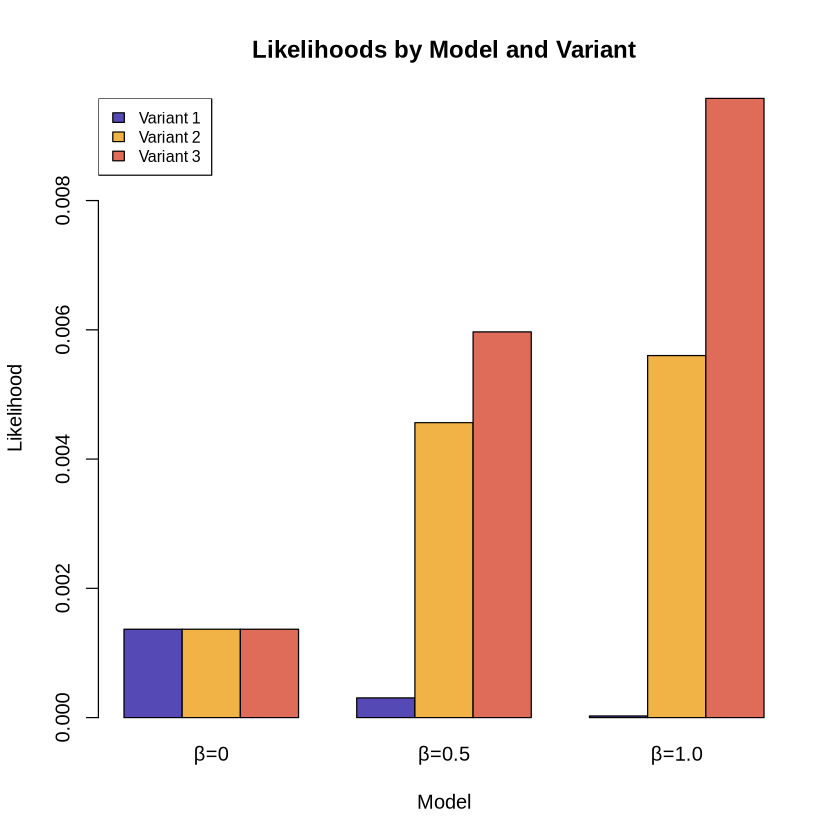

In [29]:
# First, let's create a plot to compare likelihoods across models for each variant
# Plot 1: Likelihoods for all models and variants
barplot(as.matrix(results_table[, c("L_Model1", "L_Model2", "L_Model3")]), 
        beside = TRUE, 
        names.arg = c("β=0", "β=0.5", "β=1.0"),
        col = c("#5549b6", "#f1b246", "#df6b59"),
        main = "Likelihoods by Model and Variant",
        xlab = "Model", ylab = "Likelihood",
        ylim = c(0, max(results_table[, c("L_Model1", "L_Model2", "L_Model3")])))
legend("topleft", 
       legend = paste("Variant", 1:3), 
       fill = c("#5549b6", "#f1b246", "#df6b59"),
       cex = 0.8)


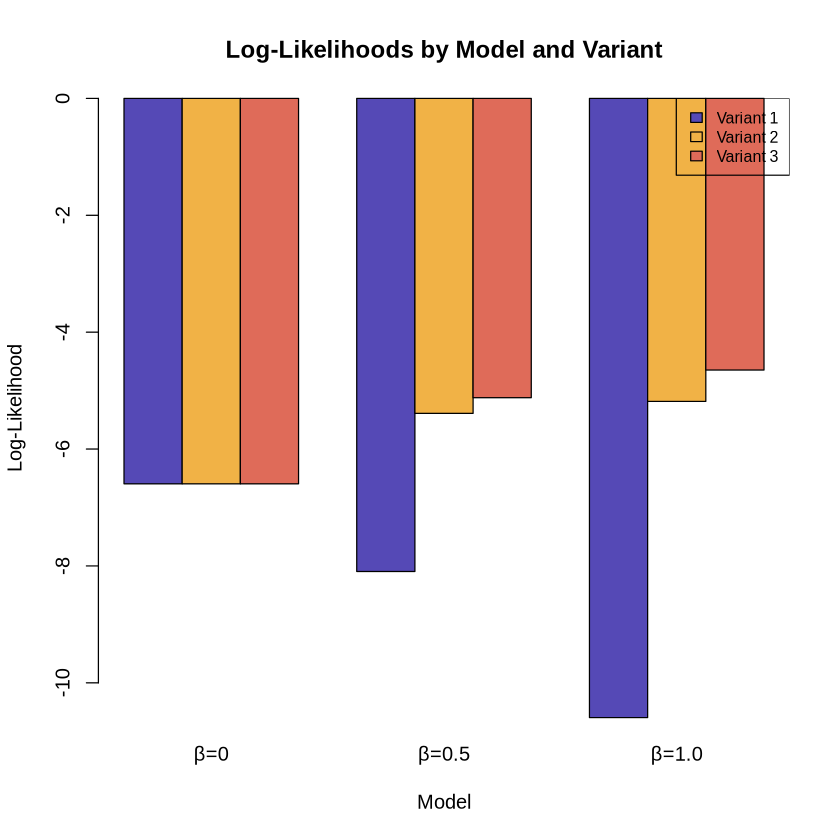

In [30]:
# Plot 2: Log-likelihoods for all models and variants
barplot(as.matrix(results_table[, c("LogL_Model1", "LogL_Model2", "LogL_Model3")]),
    beside = TRUE,
    names.arg = c("β=0", "β=0.5", "β=1.0"),
    col = c("#5549b6", "#f1b246", "#df6b59"),
    main = "Log-Likelihoods by Model and Variant",
    xlab = "Model", ylab = "Log-Likelihood",
    ylim = c(min(results_table[, c("LogL_Model1", "LogL_Model2", "LogL_Model3")]), 0)
)
legend("topright",
    legend = paste("Variant", 1:3),
    fill = c("#5549b6", "#f1b246", "#df6b59"),
    cex = 0.8
)


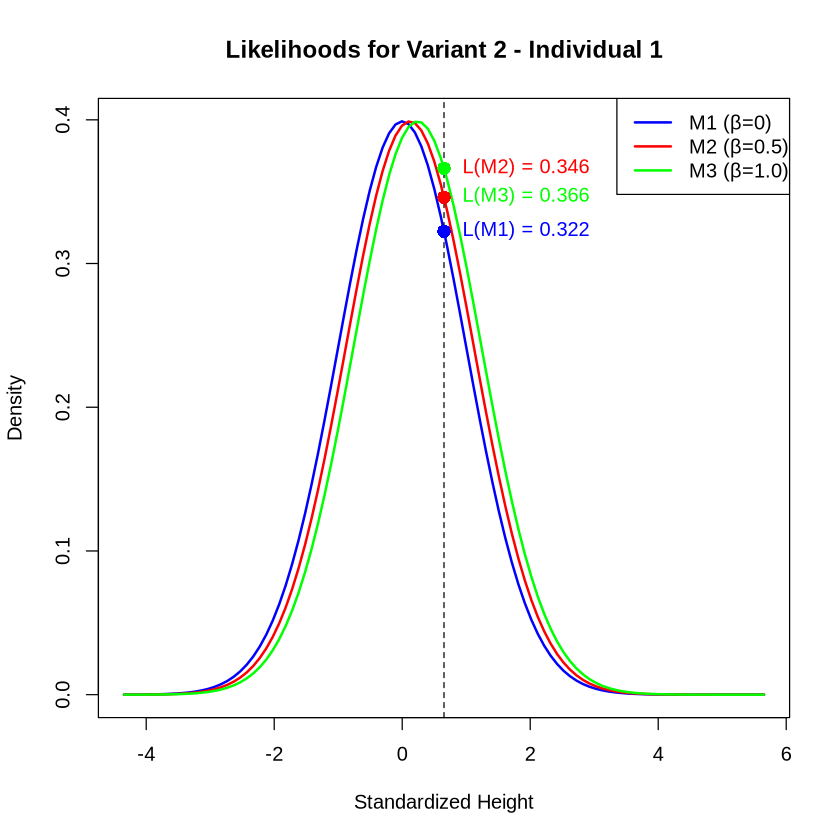

In [40]:
# Set up parameters for Variant 2
variant_idx <- 2
X_j <- X[, variant_idx]

# Let's use the first individual as an example
ind_idx <- 1
height_value <- Y[ind_idx]
genotype <- X_j[ind_idx]

# Set up parameters
baseline <- 0 # For standardized data, baseline is 0
sd_y <- sd_assumed # Using the assumed standard deviation of 1

# Create a sequence of x values for plotting the density
x_vals <- seq(height_value - 5, height_value + 5, length.out = 100)

# Compute the likelihood densities for three models
likelihood_1_curve <- dnorm(x_vals, mean = baseline, sd = sd_y)
likelihood_2_curve <- dnorm(x_vals, mean = baseline + 0.5 * genotype, sd = sd_y)
likelihood_3_curve <- dnorm(x_vals, mean = baseline + 1.0 * genotype, sd = sd_y)

# Plot the likelihood curves
plot(x_vals, likelihood_1_curve,
    type = "l", col = "blue", lwd = 2,
    xlab = "Standardized Height", ylab = "Density",
    main = paste("Likelihoods for Variant", variant_idx, "- Individual", ind_idx),
    ylim = c(0, max(c(likelihood_1_curve, likelihood_2_curve, likelihood_3_curve)))
)
lines(x_vals, likelihood_2_curve, col = "red", lwd = 2)
lines(x_vals, likelihood_3_curve, col = "green", lwd = 2)

# Add vertical dashed line to show the observed height value
abline(v = height_value, col = "black", lty = 2)

# Add labels for the likelihood values at the height value for all models
y_label_1 <- dnorm(height_value, mean = baseline, sd = sd_y)
y_label_2 <- dnorm(height_value, mean = baseline + 0.5 * genotype, sd = sd_y)
y_label_3 <- dnorm(height_value, mean = baseline + 1.0 * genotype, sd = sd_y)

# Offset the text positions to avoid overlap
text(height_value + 0.1, y_label_1, labels = paste("L(M1) =", round(y_label_1, 3)), pos = 4, col = "blue")
text(height_value + 0.1, y_label_2 + 0.02, labels = paste("L(M2) =", round(y_label_2, 3)), pos = 4, col = "red")
text(height_value + 0.1, y_label_3 - 0.02, labels = paste("L(M3) =", round(y_label_3, 3)), pos = 4, col = "green")

# Add points at the intersection of the height value on all curves
points(height_value, y_label_1, col = "blue", pch = 16, cex = 1.5)
points(height_value, y_label_2, col = "red", pch = 16, cex = 1.5)
points(height_value, y_label_3, col = "green", pch = 16, cex = 1.5)

# Add a legend
legend("topright",
    legend = c("M1 (β=0)", "M2 (β=0.5)", "M3 (β=1.0)"),
    col = c("blue", "red", "green"), lwd = 2
)


# Supplementary Materials

Here we provide more examples to help you understand the likelihood.

## Example 1 -- allele frequency of elephant

### Description of the question

Here we use an example from [Matthew Stephen's notes](http://stephens999.github.io/fiveMinuteStats/likelihood_ratio_simple_models.html).

> [Technical Note: to simplify this problem I have assumed that elephants are haploid, which they are not. If you do not know what this means you should simply ignore this comment.]
>
> There are two subspecies of African Elephant: savannah and forest elephants, which differ in their genetic makeup. Interpol have seized an illegally-smuggled elephant tusk, and they want to know which subspecies of elephant the tusk came from. To try to answer this they collect DNA from the tusk and measure it at a number of locations (“markers” in genetics jargon) along the elephant genome. At each marker the DNA can be one of two types (“alleles” in genetics jargon), which for simplicity we will label 0 and 1. So the available data on the tusk might look something like this.
> 
> |Marker|Allele|
|:--:|:--:|
|1|	1|
|2|0|
|3|1|
|4|0|
|5|0|
|6|1|

In [ ]:
x = c(1,0,1,0,0,1)

> Interpol also have information on the frequency of each allele in each of the two subspecies - this was obtained by measuring the DNA of a large number of savanna elephants and a large number of forest elephants. We will use $f_{S{j}}$ and $f_{F{j}}$ to denote the frequency of “1” allele at marker j in savanna and forest elephants respectively (and since there are only two alleles, the frequency of the 0 allele is $1−f_{S{j}}$ and $1−f_{F{j}}$). Here is a table of this information.
>
> | marker | $f_S$  | $f_F$  |
|:--------:|:-----:|:-----:|
| 1      | 0.40 | 0.80 |
| 2      | 0.52 | 0.20 |
| 3      | 0.21 | 0.51 |
| 4      | 0.52 | 0.57 |
| 5      | 0.02 | 0.23 |
| 6      | 0.32 | 0.25 |


In [ ]:
fS = c(0.40, 0.52,0.21,0.52,0.02,0.32)
fF = c(0.8,0.2,0.51,0.57,0.23,0.25)

> The question before us is: **Which subspecies of elephant did the tusk come from, and how confident should we be in this conclusion?**

### Solution

> We can phrase this problem as a “model comparison” problem. We have data $X=x$ from our tusk, and we have two different models for how those data might have arisen: it could have been sampled from a savanna elephant, or it could have been sampled from a forest elephant. We will use $M_S$ and $M_F$ as shorthand for these two models. A key point is that these two models imply different probability distributions for $X$: some values of $X$ are more common under $M_S$ and others are more common under $M_F$.
>
> Denoting the probability mass functions of these two distributions p(⋅|MS) and p(⋅|MF), and assuming the data at different markers are independent, these probability distributions are:
> $$
p(x|M_S)=\prod_j f_{S_j}^{x_j}(1−f_{S_j})^{1−x_j}
$$
>
> and
> $$
p(x|M_F)=\prod_j f_{F_j}^{x_j}(1−f_{F_j})^{1−x_j}
$$
>>
>
> where the values of $f_S$ and $f_F$ are given in the table above.
>
> The key idea to introduce here is that a useful summary of how strongly the data $x$ support one model vs another model is given by the “likelihood ratio” (LR).

**So before we drive ourselves into the likelihood ratio of two methods, in this notebook, let's focus on the likelihood:**

The **"likelihood"** for a model is defined as the probability of the data under the model. That is, given data $x$, the likelihood for a fully-specified (discrete) model M is defined as

$$
L(M_S)=p(x|M_S)=\prod_j f_{S_j}^{x_j}(1−f_{S_j})^{1−x_j} \\
L(M_F)=p(x|M_F)=\prod_j f_{F_j}^{x_j}(1−f_{F_j})^{1−x_j}
$$
where $p(⋅|M)$ denotes the probability mass function for model $M$.

In [ ]:
L = function(f,x){ prod(f^x*(1-f)^(1-x)) }

In [ ]:
L(fS,x)

In [ ]:
L(fF,x)

## Example 2 -- concentration of protein in the blood 

### Description

> A medical screening test for a disease involves measuring the concentration ($X$) of a protein in the blood. In normal individuals $X$ has a Gamma distribution with mean 1 and shape 2. In diseased individuals the protein becomes elevated, and $X$ has a Gamma distribution with mean 2 and shape 2. Plotting the probability density functions of these distributions yields:
> 

Suppose that for a particular individual we observe $X=4.02$. Then the question is

**Is this individual from the normal group or the diseased group?**

### Solution

The likelihood for the two models -- normal individual group ($M_0$) or diseased individual group ($M_1$) --- can therefore be calculated as:


$$
L(M_0)=p(x|M_0)= \frac{\beta_0^{\alpha_0} x^{\alpha_0 - 1} e^{-\beta_0 x}}{\Gamma(\alpha_0)} = \frac{2^2 \cdot 4.02^{2 - 1} e^{-2 \cdot 4.02}}{\Gamma(2)}\\
L(M_1)=p(x|M_1)= \frac{\beta_1^{\alpha_1} x^{\alpha_1 - 1} e^{-\beta_1 x}}{\Gamma(\alpha_1)} = \frac{1^2 \cdot 4.02^{2 - 1} e^{-1 \cdot 4.02}}{\Gamma(2)}
$$


The difference here is that instead of the **probability mass functions** that we used in the first example, here we use the **probability density functions (PDF)** of Gamma distribution:

$$
f(x; \alpha, \beta) = \frac{\beta^\alpha x^{\alpha - 1} e^{-\beta x}}{\Gamma(\alpha)}, \quad x > 0
$$


where:
- $\alpha$ is the shape parameter,
- $\beta$ is the rate parameter ($\beta = \frac{1}{\theta}$, where $\theta$ is the scale parameter),
- $\Gamma(\alpha)$ is the Gamma function.

In [ ]:
X_val=4.02

In R we can use the [dgamma](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/GammaDist.html) function to calculate the PDF of gamma function at data $x$.

In [ ]:
# dgamma(x, shape, rate = 1, scale = 1/rate, log = FALSE) returns the Density for the Gamma distribution with parameters shape and scale at x
y0_val = dgamma(X_val,scale=0.5,shape=2)
y1_val = dgamma(X_val,scale=1,shape=2)

This can be visualized from the figure below. 

In [ ]:
x <- seq(0, 10, length = 100)

# Compute density values
y0 <- dgamma(x, scale = 0.5, shape = 2)
y1 <- dgamma(x, scale = 1, shape = 2)

# Plot the first Gamma density
plot(x, y0, type = "l", xlab = "Protein Concentration", ylab = "Density",
     col = "black", lwd = 2, ylim = c(0, max(y0, y1)))

# Add the second Gamma density
lines(x, y1, col = "red", lwd = 2)

# Add a vertical line at x = 4.02
abline(v = X_val, lty = 2, col = "blue")

# Mark the corresponding points
points(X_val, y0_val, col = "black", pch = 19, cex = 1.2) # normal group
points(X_val, y1_val, col = "red", pch = 19, cex = 1.2) # diseased group

# Add text labels near the points
text(X_val, y0_val, labels = round(y0_val, 4), pos = 3, col = "black")
text(X_val, y1_val, labels = round(y1_val, 4), pos = 3, col = "red")

# Add legend
legend("topright", legend = c("Gamma(0.5, 2)", "Gamma(1, 2)"), 
       col = c("black", "red"), lwd = 2, bty = "n")


# Recommended Reading

- Statistical Rethinking, 2nd Edition, Section 2.1, 2.3, 2.4.
- Section *Likelihood Ratio and Likehood* in [FiveMinuteStats](http://stephens999.github.io/fiveMinuteStats/index.html) by Matthew Stephens
